In [271]:
"""
This is based on the linear regression tutorial from tensorflow.
https://www.tensorflow.org/tutorials/keras/regression
"""

"Auto reload code"
%reload_ext autoreload
%autoreload 2

"Show plots in notebook"
%matplotlib inline

# Part 1:

## Data cleaning

In [272]:
import os

dataset_path = os.path.realpath('./auto-mpg.data')
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)\
                .dropna()

"""
Modify origin column using a one hot approach.
1: USA
2: Europe
3: Japan
"""
origin = df.pop('Origin')
df['USA'] = (origin == 1)*1.0
df['Europe'] = (origin == 2)*1.0
df['Japan'] = (origin == 3)*1.0

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


# Part 2:

## Split data into train and test datasets

,count,mean,std,min,25%,50%,75%,max
Cylinders,313.0,5.399361,1.684279,3.0,4.0,4.0,6.0,8.0
Displacement,313.0,189.407348,102.088783,68.0,98.0,141.0,258.0,455.0
Horsepower,313.0,102.447284,37.096953,46.0,75.0,92.0,116.0,230.0
Weight,313.0,2936.591054,832.024407,1613.0,2219.0,2740.0,3525.0,4997.0
Acceleration,313.0,15.665495,2.756965,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,76.006390,3.718452,70.0,73.0,76.0,79.0,82.0
USA,313.0,0.610224,0.488480,0.0,0.0,1.0,1.0,1.0
Europe,313.0,0.175719,0.381190,0.0,0.0,0.0,0.0,1.0
Japan,313.0,0.214058,0.410824,0.0,0.0,0.0,0.0,1.0


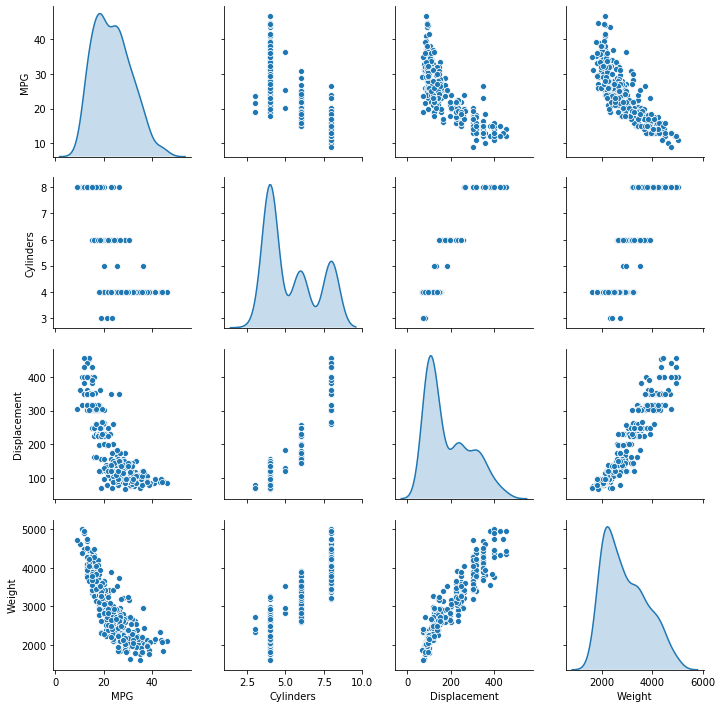

In [273]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=None)

import seaborn as sns
sns.pairplot(train_df[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

target_label = 'MPG'

"""
Gather some stats about the training data
"""
train_stats = train_df.describe()
train_stats.pop(target_label)
train_stats = train_stats.transpose()
display(train_stats)

"Remove label from the set of features. MPG (Miles per gallon) is what we're trying to predict"
train_labels = train_df.pop(target_label)
test_labels = test_df.pop(target_label)

# z-score
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

def denorm(x):
    return (x * train_stats["std"] + train_stats["mean"])

"Normalize data to make the model more performant as it helps it converge faster."
normed_train_df = norm(train_df)
normed_test_df = norm(test_df)

# Part 3

## Model definition

In [274]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
Define the network as a stack of layers
"""
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(normed_train_df.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


# Part 4

## Train the model

In [275]:
import os
import datetime

# start tensorboard inside notebook
%reload_ext tensorboard
%tensorboard --logdir logs

"""
Custom callback for knowing when a certain epoch is done
"""
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
"If the model accuracy doesn't improve, stop training"
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
logdir = os.path.join('logs/notebook', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

"Train the model"
model.fit(
  normed_train_df, train_labels,
  epochs=1000, validation_split = 0.2,
  verbose=0, batch_size=512,
  callbacks=[
      tensorboard_callback,
      early_stop,
      PrintDot()
  ])

Reusing TensorBoard on port 6006 (pid 10341), started 0:38:54 ago. (Use '!kill 10341' to kill it.)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................

# Part 5

## Evaluate model using test dataset

In [276]:
"Make predictions using test test dataset that the model haven't seen so far"
loss, mae, mse = model.evaluate(normed_test_df, test_labels, verbose=2)
print('Testing set Loss: {:5.2f}'.format(loss))
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print('Testing set Mean Square Error: {:5.2f}'.format(mse))

79/79 - 0s - loss: 9.0543 - mae: 1.9075 - mse: 9.0543
Testing set Loss:  9.05
Testing set Mean Abs Error:  1.91
Testing set Mean Square Error:  9.05


# Part 6

## Make predictions

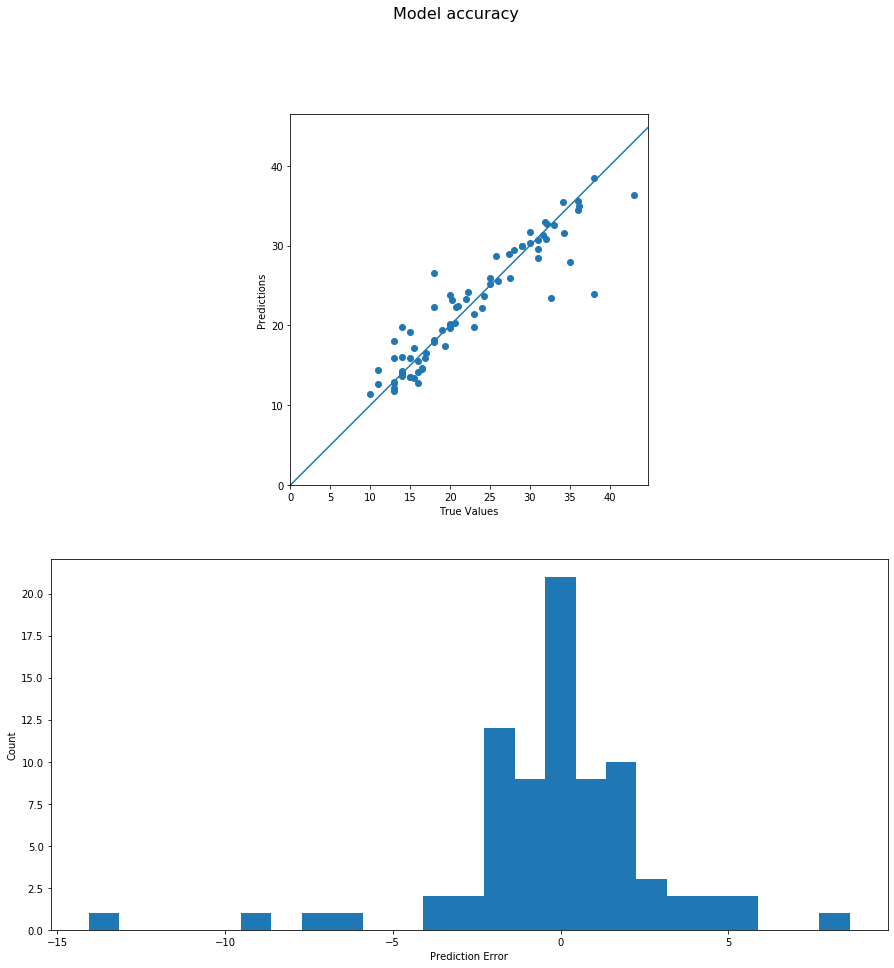

In [277]:
test_predictions = model.predict(normed_test_df).flatten()

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15))
fig.suptitle('Model accuracy', fontsize=16)

ax1.scatter(test_labels, test_predictions)
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predictions')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0, ax1.get_xlim()[1]])
ax1.set_ylim([0, ax1.get_ylim()[1]])
ax1.plot([-100, 100], [-100, 100])

error = test_predictions - test_labels
ax2.hist(error, bins = 25)
ax2.set_xlabel("Prediction Error")
ax2.set_ylabel("Count")

plt.show()

# Part 7

## Save/load the model to disk for future use

In [278]:
"Save model to disk"

model.save('models/model.h5')

"Load model from disk"
loaded = tf.keras.models.load_model('models/model.h5')
loaded.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [279]:
"Test if we still can do predictions"
batch_size = 10
normalized_example = normed_train_df[:batch_size]
combined = pd.concat([train_df[:batch_size], train_labels[:batch_size]], axis=1)
combined["Prediction"] = loaded.predict(normalized_example)
display(combined)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan,MPG,Prediction
100,6,250.0,88.0,3021.0,16.5,73,1.0,0.0,0.0,18.0,18.369509
2,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0,18.0,17.361282
392,4,151.0,90.0,2950.0,17.3,82,1.0,0.0,0.0,27.0,26.946562
261,6,258.0,120.0,3410.0,15.1,78,1.0,0.0,0.0,18.1,19.260748
230,8,350.0,170.0,4165.0,11.4,77,1.0,0.0,0.0,15.5,15.710152
369,4,112.0,88.0,2395.0,18.0,82,1.0,0.0,0.0,34.0,30.584021
34,6,225.0,105.0,3439.0,15.5,71,1.0,0.0,0.0,16.0,16.949467
329,4,91.0,67.0,1850.0,13.8,80,0.0,0.0,1.0,44.6,36.866959
85,8,350.0,175.0,4100.0,13.0,73,1.0,0.0,0.0,13.0,12.431917
236,4,140.0,89.0,2755.0,15.8,77,1.0,0.0,0.0,25.5,24.806076
